<a href="https://colab.research.google.com/github/DiegoLeonG96/Tarea3_MLA/blob/main/Tarea_3_MLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Profesor: Tomás Fontecilla</em><br>

</div>

# **Machine Learning Avanzado: Tarea N°3**
*17 de diciembre de 2024*

Integrantes:

- Julio Assmann
- Diego León
- Sofía Vits

## Introducción y objetivos

En el presente informe se presentan dos arquitecturas de redes neuronales en dos diferentes tareas. Una primera arquitectura es un autoencoder convolucional que se busca que pueda reducir o eliminar el "ruido" presente en la imagen. Una segunda arquitectura de red neuronal es una red neuronal LSTM, la cual se entrena sobre series de tiempo para predecir tres meses a futuro.

El objetivo principal es lograr una familiarización con ambas arquitecturas de redes neuronales, incluyendo su estructura y adecuado nivel de generalización.

Como objetivos secundadios, se busca en primer lugar ajustar la arquitectura autoencoder para limpiar imágenes y obtener el texto en ellas. La base de imágenes que se utiliza es denoising-dirty-documents (https://www.kaggle.com/c/denoising-dirty-documents). Adicionalmente se debe limpia r una imagen propia utilizando el modelo autoencoder entrenado con las imágenes con ruido y sin ruido (arrugas, manchas, entre otros). En segundo lugar, se busca entrenar una arquitectura LSTM a datos de producción láctea y al IPSA obtenido desde el Banco Central.

## Metodología

### Autoencoder

1.- Carga y exploración de las imágenes con ruido y sin ruido: <br>
Utilizando numpy y opencv de python (cv2) se cargan las imágenes de train y test, además de las imágenes target (limpias). El conjunto de train original se divide en train y validación para poder validar métricas durante el entrenamiento, ya que el conjunto de "test" en este
dataset no poseen target (imagen limpia).

2.- Entrenamiento y prueba del modelo autoencoder utilizando las imágenes del dataset denoising-dirty-documents: <br>
Se propone una arquitectura de autoencoder convolucional con valores
típicos de filtros (múltiplos de 16) y esta se va mejorando incorporando batch normalization, dropout como también capas convolucionales con una mayor cantidad de filtros. El entrenamiento
se procura que no tenga overfitting y se evalúa visualmente algunos ejemplos de test con el objetivo de ver que se "limpien" correctamente
las imágenes.


3.- Utilización de autoenconder con imagen propia: <br>
Se utiliza una imagen externa al dataset con el fin de ver el nivel
de generalización del modelo

### LSTM

4.- Carga y exploración de las series de tiempo del dataset monthly_milk_production y del dataset IPSA:<br>
Corresponde a datos mensuales en ambos casos, las cuales se les realiza un estudio de tendencias y componentes

5.- Entrenamiento y prueba de arquitectura LSTM para producción de leche e IPSA<br>
En ambos casos se utiliza un horizonte de predicción de 3 meses y se experimenta un número de autoregresores. Las LSTM se procura experimentar con el número de unidades en capa oculta, con el fin de obtener un adecuado nivel de generalización

6.- Predicción de LSTM 3 meses adelante para producción de leche e IPSA
Utilizando las porciones de tiempo finales de cada serie reservadas para test, se evalúan las predicciones a 3 meses y se extraen métricas regresivas con el Mean Squared Error (MSE).

## Desarrollo de los modelos autoencoder y LSTM

In [1]:
!pip install ruptures

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.0 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from keras import models, layers, optimizers, regularizers
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import random
import kagglehub
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as adfuller
import ruptures as rpt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from tensorflow.keras.callbacks import EarlyStopping
# Establecer la semilla para Python
random.seed(42)

# Establecer la semilla para NumPy
np.random.seed(42)

# Establecer la semilla para TensorFlow
tf.random.set_seed(42)

### Autoencoder

#### Carga de datos

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving denoising-dirty-documents.zip to denoising-dirty-documents.zip


In [ ]:
!unzip denoising-dirty-documents.zip
!unzip train.zip
!unzip train_cleaned.zip
!unzip test.zip

Archive:  denoising-dirty-documents.zip
  inflating: sampleSubmission.csv.zip  
  inflating: test.zip                
  inflating: train.zip               
  inflating: train_cleaned.zip       
Archive:  train.zip
   creating: train/
  inflating: train/101.png           
  inflating: train/102.png           
  inflating: train/104.png           
  inflating: train/105.png           
 extracting: train/107.png           
 extracting: train/108.png           
 extracting: train/11.png            
  inflating: train/110.png           
 extracting: train/111.png           
  inflating: train/113.png           
  inflating: train/114.png           
 extracting: train/116.png           
  inflating: train/117.png           
 extracting: train/119.png           
 extracting: train/12.png            
 extracting: train/120.png           
  inflating: train/122.png           
 extracting: train/123.png           
  inflating: train/125.png           
  inflating: train/126.png           
  infl

In [ ]:
!ls

denoising-dirty-documents.zip  sampleSubmission.csv.zip  test.zip  train_cleaned      train.zip
sample_data		       test			 train	   train_cleaned.zip


In [ ]:
import cv2
import os
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #escala de grises
    img = img/255.0 # normalizar
    img = np.reshape(img, (420, 540, 1))

    return img

X_train = []
y_train = []
X_test = []

# train
for f in sorted(os.listdir('train/')):
    X_train.append(process_image('train/' + f))

# target (limpias)
for f in sorted(os.listdir('train_cleaned/')):
    y_train.append(process_image('train_cleaned/' + f))

# test
for f in sorted(os.listdir('test/')):
    X_test.append(process_image('test/' + f))

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)

#### Exploración de datos

In [ ]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (144, 420, 540, 1)
X_test shape: (72, 420, 540, 1)


Función para mostrar imágenes de ejemplo

In [ ]:
def plot_images_in_grid(images, titles, n_examples=10, n_rows=2, figsize=(15, 5)):
    """
    Generaliza la creación de una grilla para mostrar imágenes.

    Parameters:
    - images: Lista de imágenes a mostrar.
    - titles: Lista de títulos para cada imagen.
    - n_examples: Número máximo de ejemplos a mostrar.
    - n_rows: Número de filas en la grilla.
    - figsize: Tamaño de la figura (tupla).
    """
    n_cols = (n_examples + n_rows - 1) // n_rows
    fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)

    # Convertir ax a una lista, incluso si es un único objeto
    if n_rows == 1 or n_cols == 1:
        ax = np.array(ax).flatten()
    else:
        ax = ax.flatten()

    for idx in range(len(ax)):
        if idx < n_examples and idx < len(images):
            ax[idx].imshow(images[idx], cmap = 'gray')
            ax[idx].set_title(titles[idx])
            ax[idx].axis('off')
        else:
            ax[idx].axis('off')

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()


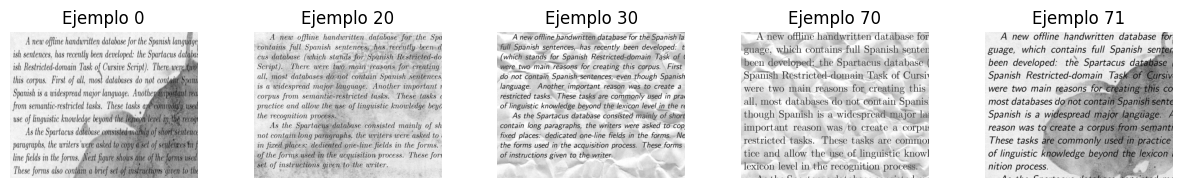

In [ ]:
example_idx = [0, 20, 30, 70, 71]
filtered_images = [X_test[img_idx]/255 for img_idx in example_idx]
filtered_titles = [f'Ejemplo {img_idx}' for img_idx in example_idx]

plot_images_in_grid(filtered_images, filtered_titles, n_examples=len(filtered_images), n_rows=1)

Se pueden ver imágenes con manchas excesivas (ejemplo 0 y 71), manchas
tenues (ejemplo 20) e imágenes arrugadas (30 y 70).

#### Modelo autoencoder y entrenamiento

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42)

In [ ]:
from keras import backend as K
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

Primer modelo, 2 capas convolucionales, sin batch normalization ni max pooling. Capas con 32 y 64 filtros

In [ ]:
class ConvAutoEncoder1(Model):
    def __init__(self, input_shape):
        super().__init__()

        # Encoder
        self.encoder = Sequential([
            Input(shape=input_shape),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),
        ])

        # Decoder
        self.decoder = Sequential([
            Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
            UpSampling2D((2, 2)),
            Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

Se usan 50 épocas base, puede parar con early stopping, y en el caso
que el modelo no alcance a converger sería necesario aumentar el número de épocas.

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 0.0782 - mse: 0.2231 - val_loss: 0.0755 - val_mse: 0.2151
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - loss: 0.0740 - mse: 0.2118 - val_loss: 0.0709 - val_mse: 0.2025
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - loss: 0.0690 - mse: 0.1982 - val_loss: 0.0651 - val_mse: 0.1863
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - loss: 0.0627 - mse: 0.1805 - val_loss: 0.0569 - val_mse: 0.1629
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - loss: 0.0537 - mse: 0.1544 - val_loss: 0.0465 - val_mse: 0.1311
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - loss: 0.0430 - mse: 0.1214 - val_loss: 0.0366 - val_mse: 0.0982
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - loss: 0.0338 - mse: 0.0899 - val_loss: 0.0307 - val_mse: 0.0757
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - loss: 0.0289 - mse: 0.0706 - val_loss: 0.0290 - val_mse: 0.0671
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step - loss: 0.0277 - mse: 0.

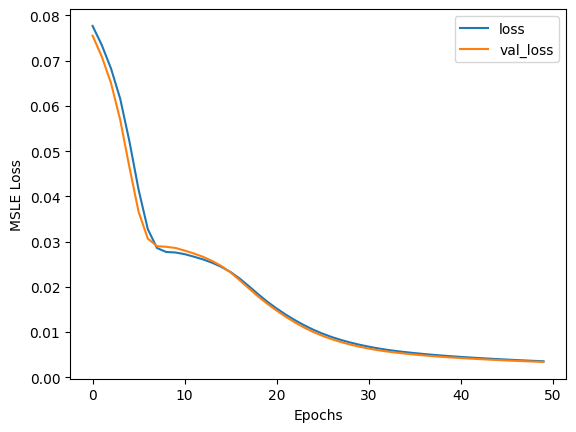

In [ ]:
image_size=(420, 540)
model = ConvAutoEncoder1(input_shape = (image_size[0], image_size[1], 1))
# configurations of model
lr = 1e-4
model.compile(loss='msle', metrics =['mse'], optimizer = optimizers.Adam(learning_rate=lr))
callback = EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[callback]
)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

No se observa overfitting y se observa convergencia en las funciones de pérdida.

Segundo modelo duplicando los números de filtros en capas convolucionales.

In [ ]:
class ConvAutoEncoder2(Model):
    def __init__(self, input_shape):
        super().__init__()

        # Encoder
        self.encoder = Sequential([
            Input(shape=input_shape),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),
        ])

        # Decoder
        self.decoder = Sequential([
            Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
            Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            UpSampling2D((2, 2)),
            Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 70s 7s/step - loss: 0.0738 - mse: 0.2109 - val_loss: 0.0568 - val_mse: 0.1622
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 628ms/step - loss: 0.0514 - mse: 0.1470 - val_loss: 0.0389 - val_mse: 0.1058
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 619ms/step - loss: 0.0349 - mse: 0.0934 - val_loss: 0.0300 - val_mse: 0.0718
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 630ms/step - loss: 0.0284 - mse: 0.0672 - val_loss: 0.0297 - val_mse: 0.0670
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 617ms/step - loss: 0.0285 - mse: 0.0647 - val_loss: 0.0301 - val_mse: 0.0674
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 637ms/step - loss: 0.0287 - mse: 0.0648 - val_loss: 0.0295 - val_mse: 0.0663
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 616ms/step - loss: 0.0280 - mse: 0.0636 - val_loss: 0.0288 - val_mse: 0.0657
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 619ms/step - loss: 0.0275 - mse: 0.0637 - val_loss: 0.0285 - val_mse: 0.0664
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 635ms/step - loss: 0.0272 - mse: 0

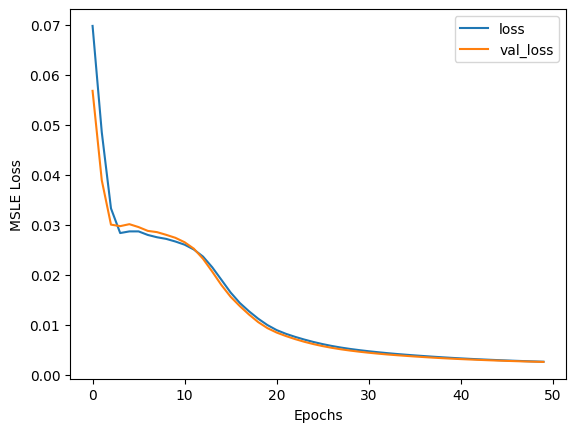

In [ ]:
image_size=(420, 540)
model = ConvAutoEncoder2(input_shape = (image_size[0], image_size[1], 1))
# configurations of model
lr = 1e-4
model.compile(loss='msle', metrics =['mse'], optimizer = optimizers.Adam(learning_rate=lr))
callback = EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[callback]
)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

Se observa una convergencia similar, pero el MSE final en validación es menor que el primer modelo, por lo cual es preferible a éste.

Tercer modelo. Se añade batch normalization y dropout.

In [ ]:
class ConvAutoEncoder3(Model):
    def __init__(self, input_shape):
        super().__init__()

        # Encoder
        self.encoder = Sequential([
            Input(shape=input_shape),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2), padding='same'),
            Dropout(0.5)
        ])

        # Decoder
        self.decoder = Sequential([
            Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
            Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((2, 2)),
            Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 96s 8s/step - loss: 0.0720 - mse: 0.2064 - val_loss: 0.0626 - val_mse: 0.1782
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 53s 667ms/step - loss: 0.0565 - mse: 0.1624 - val_loss: 0.0438 - val_mse: 0.1205
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 678ms/step - loss: 0.0374 - mse: 0.1020 - val_loss: 0.0315 - val_mse: 0.0742
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 678ms/step - loss: 0.0284 - mse: 0.0668 - val_loss: 0.0318 - val_mse: 0.0710
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 689ms/step - loss: 0.0288 - mse: 0.0653 - val_loss: 0.0314 - val_mse: 0.0697
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 679ms/step - loss: 0.0280 - mse: 0.0633 - val_loss: 0.0295 - val_mse: 0.0666
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 682ms/step - loss: 0.0266 - mse: 0.0617 - val_loss: 0.0284 - val_mse: 0.0661
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 700ms/step - loss: 0.0255 - mse: 0.0600 - val_loss: 0.0267 - val_mse: 0.0600
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 657ms/step - loss: 0.0238 - m

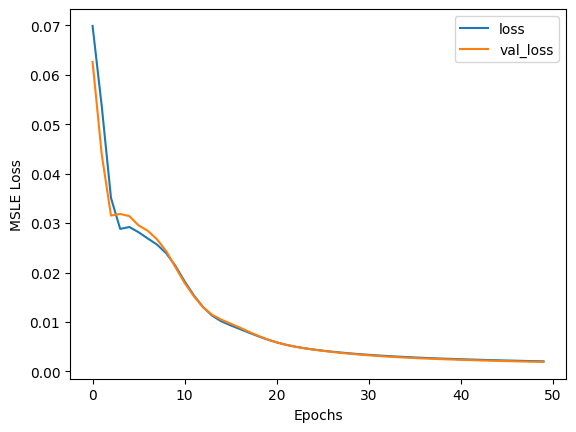

In [ ]:
image_size=(420, 540)
model = ConvAutoEncoder3(input_shape = (image_size[0], image_size[1], 1))
# configurations of model
lr = 1e-4
model.compile(loss='msle', metrics =['mse'], optimizer = optimizers.Adam(learning_rate=lr))
callback = EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[callback]
)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

Se observa un error aún menor en validación, por lo cual se trataría de la mejor configuración de la arquitectura autoencoder.

Ejemplos de salida en el conjunto de test.

In [ ]:
example_idx = [0, 20, 30, 70, 71]
image_size=(420, 540)
filtered_images = [X_test[img_idx] for img_idx in example_idx]
filtered_titles = [f'Ejemplo {img_idx}' for img_idx in example_idx]
filtered_images_preds = [model.predict(X_test[img_idx, :, :, :].reshape((1, image_size[0], image_size[1], 1))) for img_idx in example_idx]
filtered_images_preds = [img[0, :, :, :] for img in filtered_images_preds]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Ejemplos de imágenes con ruido.

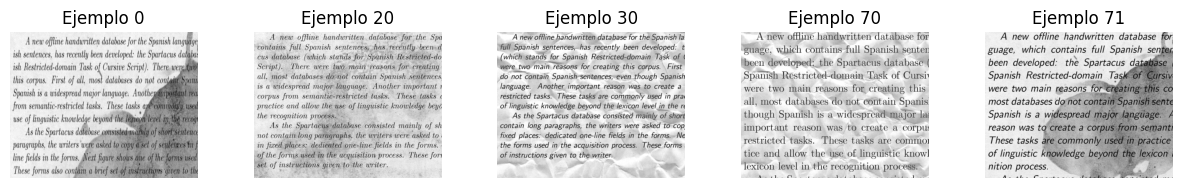

In [ ]:
plot_images_in_grid(filtered_images, filtered_titles, n_examples=len(filtered_images), n_rows=1)

Ejemplos de imágenes limpiadas luego de la aplicación del modelo autoencoder.

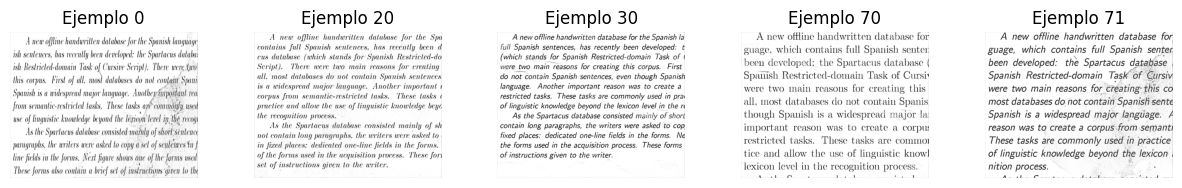

In [ ]:
plot_images_in_grid(filtered_images_preds, filtered_titles, n_examples=len(filtered_images), n_rows=1)

Se puede ver que en general en el conjunto de test se logran limpiar adecuadamente las imágenes conservando intacto el texto. Casos como el ejemplo 0 y el 71 que tenían manchas excesivas no se logran limpiar del todo, pero si se logra un estado de limpieza mayor. En el resto de casos como manchas más tenues y papeles arrugados se observa que prácticamente las imágenes quedan del todo limpias.

Ejemplo de limpieza con imagen propia.

In [ ]:
example_image  = process_image("ejemplo_sintetico.jpg")
example_image_pred = model.predict(example_image.reshape((1, image_size[0], image_size[1], 1)))

(-0.5, 539.5, 419.5, -0.5)

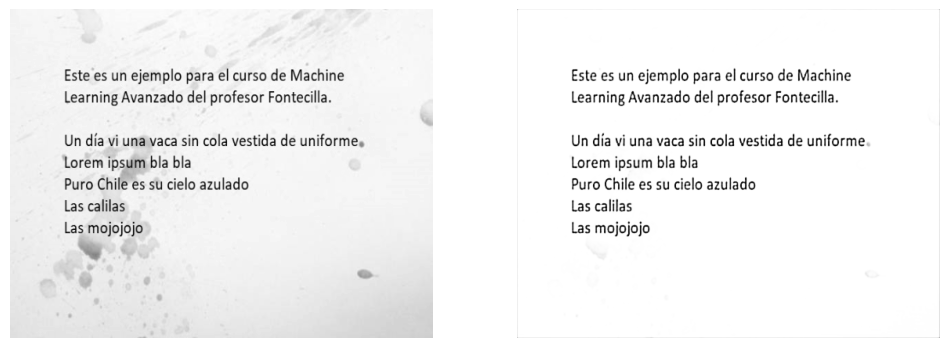

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].imshow(example_image, cmap = 'gray')
ax[1].imshow(example_image_pred[0, :, :, :], cmap = 'gray')
ax[0].axis('off')
ax[1].axis('off')

Se puede ver que en este caso, se logra limpiar correctamente las manchas impuestas en la imagen completamente. Se desprende **el gran nivel de generalización del modelo**, ya que logra cumplir su objetivo incluso en ejemplos fuera del dataset

### LSTM en producción de leche entre los años 1962 y 1975

#### Carga y exploración del dataset

In [3]:
df_leche = pd.read_csv('monthly_milk_production.csv')

In [ ]:
df_leche.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [ ]:
df_leche.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [ ]:
df_leche.shape

(168, 2)

In [4]:
df_leche['Date'] = pd.to_datetime(df_leche['Date'], errors='coerce')

In [ ]:
df_leche.isnull().sum()

,0
Date,0
Production,0


In [ ]:
df_leche.head()

,Date,Production
0,1962-01-01,589
1,1962-02-01,561
2,1962-03-01,640
3,1962-04-01,656
4,1962-05-01,727


In [ ]:
df_leche.tail()

,Date,Production
163,1975-08-01,858
164,1975-09-01,817
165,1975-10-01,827
166,1975-11-01,797
167,1975-12-01,843


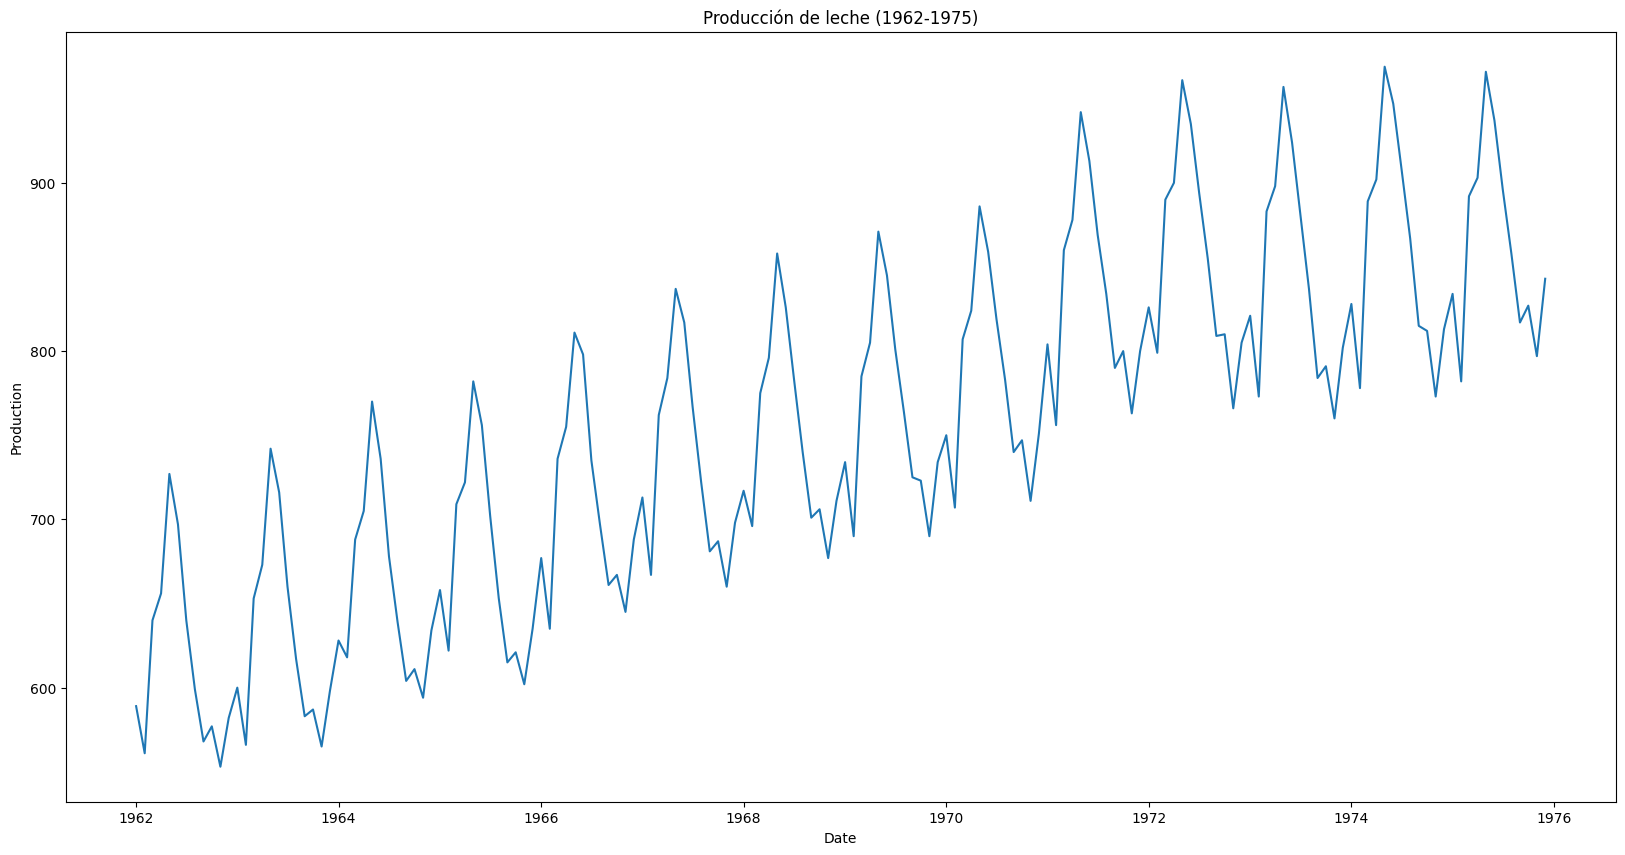

In [ ]:
# Análisis temporal: Cambios de "Production" a lo largo del tiempo
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=df_leche, x='Date', y='Production')
plt.title('Producción de leche (1962-1975)')
plt.show()

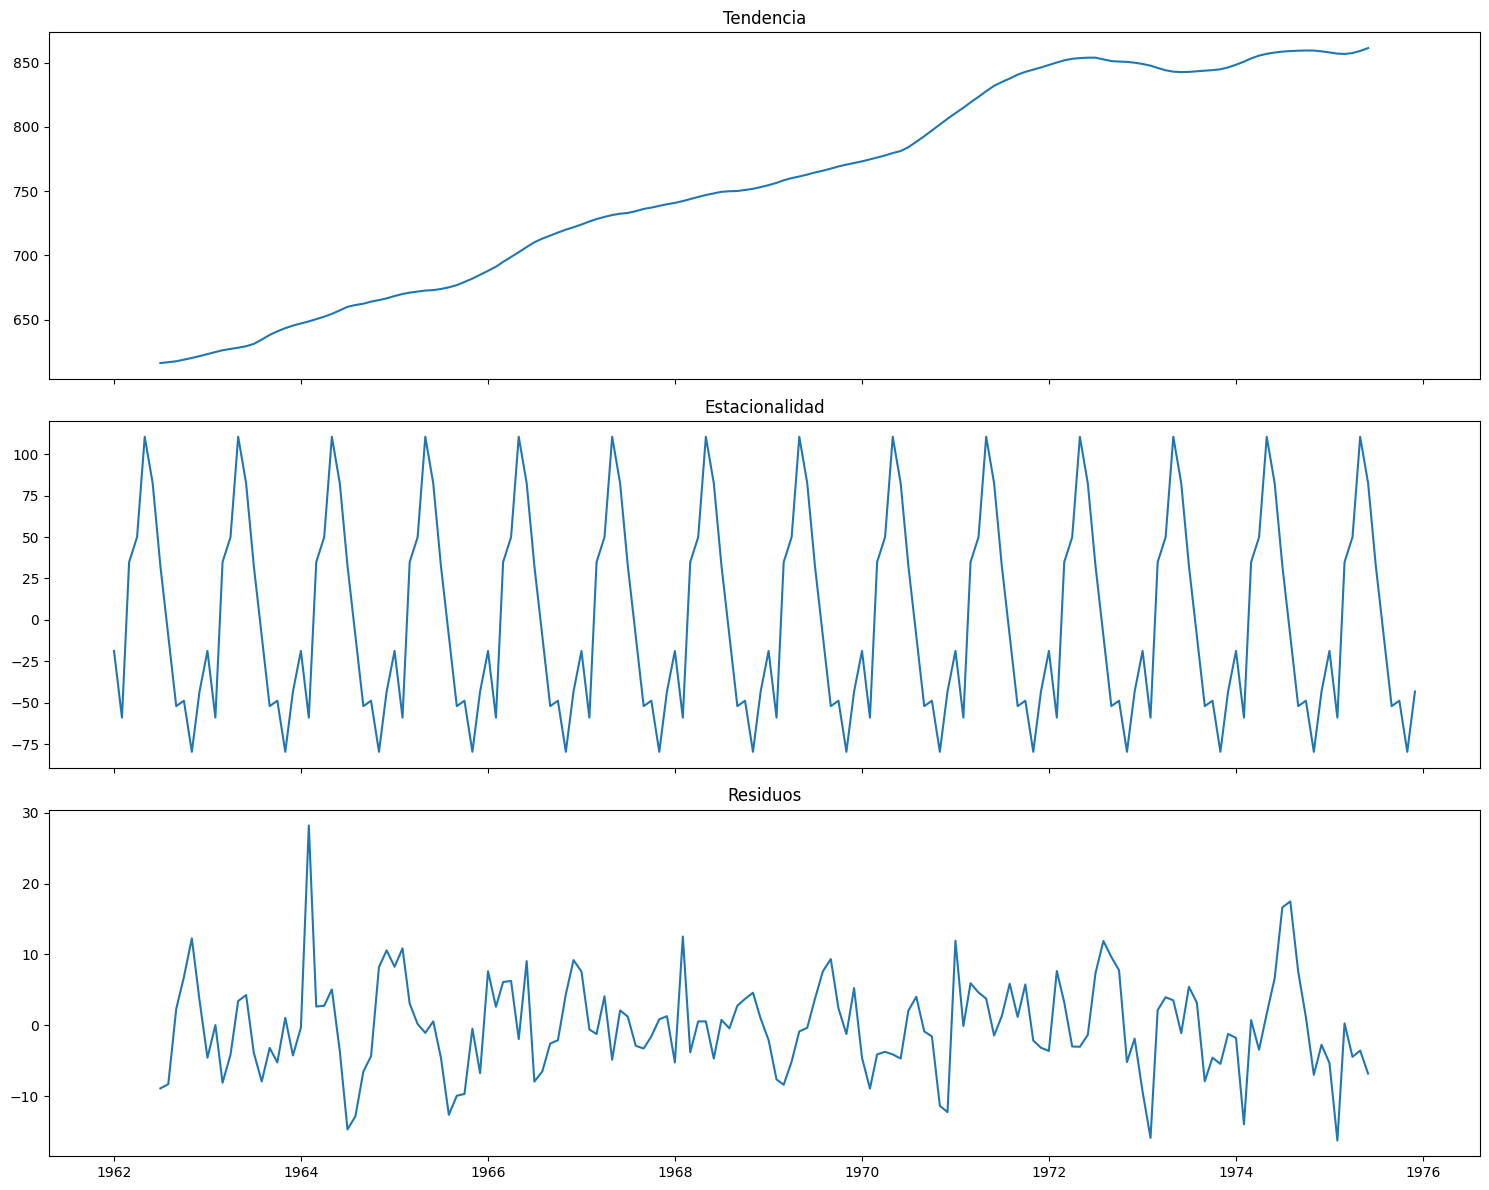

In [5]:
# Descomposición estacional
decomposition = seasonal_decompose(df_leche['Production'], model='additive', period=12)
df_leche['Trend'] = decomposition.trend
df_leche['Seasonal'] = decomposition.seasonal
df_leche['Residual'] = decomposition.resid

# Gráfico de descomposición
fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
axs[0].plot(df_leche['Date'], df_leche['Trend'], label='Trend')
axs[0].set_title('Tendencia')
axs[1].plot(df_leche['Date'], df_leche['Seasonal'], label='Seasonality')
axs[1].set_title('Estacionalidad')
axs[2].plot(df_leche['Date'], df_leche['Residual'], label='Residual')
axs[2].set_title('Residuos')
plt.tight_layout()
plt.show()

In [ ]:
df_leche['Residual'].mean()

-0.11885683760681186

Se observa una tendencia de pendiente positiva en los datos de producción de leche, lo cual implica que aumenta en el tiempo.

En el caso de la estacionalidad se observa un patrón cíclico con fluctuaciones constantes en la producción de leche entre los años 1962 y 1975.

Los residuos tienen un valor promedio igual a -0.119.

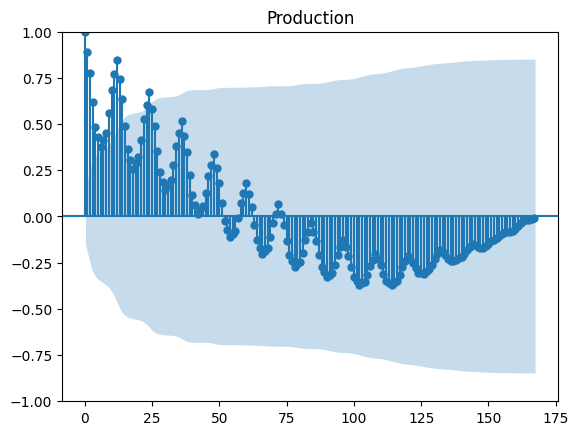

In [ ]:
# Autocorrelation
plot_acf(df_leche['Production'], lags=167, title='Production', alpha = 0.05)
plt.show()

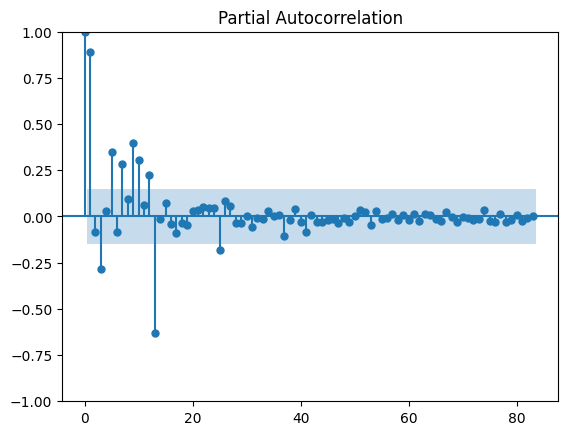

In [ ]:
# Partial Autocorrelation
plot_pacf(df_leche['Production'], lags=83)
plt.show()

Luego de observar tanto la evolución de la autocorrelación como la autocorrelación parcial de la producción de leche entre los años 1962 y 1975, podemos deducir que se trataría de una serie no estacionaria. A continuación corroboraremos este indicio aplicando la prueba de Dickey-Fuller Aumentada (ADF).

**Estacionariedad:**

Corresponde a una propiedad clave en el análisis de series temporales. Una serie temporal se considera `estacionaria`si sus propiedades estadísticas, como la media y la varianza, son constantes en el tiempo. En términos prácticos, una serie estacionaria no tiene tendencia ni estacionalidad, y cualquier cambios observado en la serie es puramente ruido aleatorio.

Para verificar si una serie temporal es estacionaria o no, una de las pruebas más utilizadas es la Prueba de **Dickey-Fuller Aumentada (ADF)**.

Esta prueba tiene las siguientes hipótesis:

**Hipótesis nula (H₀):** La serie tiene una raíz unitaria (es decir, la serie no es estacionaria).

**Hipótesis alternativa (H₁):** La serie es estacionaria.

Si el valor `p` de la prueba es menor a un nivel de significancia, como `0.05`, se rechaza la hipótesis nula y podemos concluir que la serie es estacionaria.

In [ ]:
adf_result = sts.adfuller(df_leche['Production'])

# Extraer los resultados claves
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

# Mostrar los resultados de la prueba ADF
adf_statistic, p_value, critical_values

(-1.3038115874221308,
 0.6274267086030311,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677})

Los resultados de la prueba de **Dickey-Fuller Aumentada (ADF)** para la variable **Production** son los siguientes:

- **Estadístico ADF:** resultado -1.30, cuanto más negativo sea este valor más probable es que la serie sea estacionaria. Si el estadístico ADF es menor (más negativo) que los valores críticos, se puede rechazar la hipótesis nula y concluir que la serie es estacionaria. En este caso, el valor de -1.30 no es lo suficientemente negativo para superar los valores críticos, lo que sugiere que la serie no es estacionaria.

- **Valor p:** resultado 0.63, esto significa que al ser mayor que el nivel de significancia comúnmente utilizado (0.05, o 5%), no se podría rechazar la hipótesis nula donde se establece que la serie tiene una raíz unitaria. Esto quiere decir, que la prueba sugiere que la serie `no es estacionaria`.

- **Valores críticos:**

    1% -> -3.47 El 1% respresenta un valor crítico muy conservador, lo cual quiere decir que si el estadístico ADF es menor que este valor, hay evidencia muy fuerte que la serie es estacionaria.

    5% -> -2.88 El 5% es un valor conmúnmente utilizado. Si el estadístico ADF es menor que este valor, podemos concluir que la serie es estacionaria.

    10% -> -2.58 El 10% es el valor máximo. En este caso, si el estadístico ADF es menor que este valor, la serie es estacionaria, pero menos convincente.


**En conclusión, gracias a los valores obtenidos mediante la prueba ADF, podemos indicar que la variable Production no presenta estacionariedad**

Puntos de quiebre detectados: [50, 110, 168]


<Figure size 1000x600 with 0 Axes>

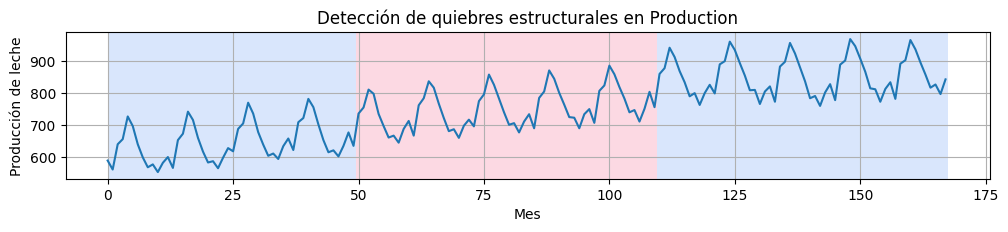

In [ ]:
# Convertir los datos a formato de numpy para aplicar la detección de quiebres
signal = df_leche['Production'].values

# Crear un modelo para detectar quiebres (usando el método de cambios de media)
algo = rpt.Pelt(model="rbf").fit(signal)

# Definir un valor para penalización (esto determina la sensibilidad para detectar quiebres)
pen = 10

# Identificar quiebres
breakpoints = algo.predict(pen=pen)

# Mostrar los puntos donde se detectaron quiebres
print("Puntos de quiebre detectados:", breakpoints)

# Visualizar los quiebres detectados
plt.figure(figsize=(10, 6))
rpt.display(signal, breakpoints)
plt.title('Detección de quiebres estructurales en Production')
plt.xlabel('Mes')
plt.ylabel('Producción de leche')
plt.grid(True)
plt.show()

Se observan quiebres en la tendencia de la producción de leche en los meses 50, 110 y 168.

In [ ]:
df_leche.head()

,Date,Production,Trend,Seasonal,Residual
0,1962-01-01,589,NaN,-18.669605,NaN
1,1962-02-01,561,NaN,-58.858707,NaN
2,1962-03-01,640,NaN,34.897703,NaN
3,1962-04-01,656,NaN,49.913729,NaN
4,1962-05-01,727,NaN,110.407318,NaN


In [6]:
df_leche_LSTM = df_leche.drop(columns=['Trend', 'Seasonal', 'Residual'])

In [ ]:
df_leche_LSTM.head()

,Date,Production
0,1962-01-01,589
1,1962-02-01,561
2,1962-03-01,640
3,1962-04-01,656
4,1962-05-01,727


In [7]:
df_leche_LSTM['Date'] = df_leche_LSTM['Date'].astype(str)

In [8]:
df_leche_LSTM["Date"] = df_leche_LSTM['Date'].str.replace('-', '')

In [ ]:
df_leche_LSTM

,Date,Production
0,19620101,589
1,19620201,561
2,19620301,640
3,19620401,656
4,19620501,727
...,...,...
163,19750801,858
164,19750901,817
165,19751001,827
166,19751101,797


In [9]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(split_percent=0.8):
    df = df_leche_LSTM
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data


def get_XY(data, input_steps, forecast_steps):

    X, Y = [], []
    for i in range(len(data) - input_steps - forecast_steps + 1):
        X.append(data[i:i+input_steps]) # input_steps hacia el pasado
        Y.append(data[i+input_steps+forecast_steps-1])  # Valor 3 meses adelante
    X = np.array(X).reshape(-1, input_steps, 1)
    Y = np.array(Y)
    return X, Y

def print_error(trainY, testY, train_predict, test_predict):
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))

# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Production')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')


Epoch 1/100
64/64 - 17s - 260ms/step - loss: 0.0448 - val_loss: 0.0876
Epoch 2/100
64/64 - 1s - 9ms/step - loss: 0.0214 - val_loss: 0.0978
Epoch 3/100
64/64 - 1s - 8ms/step - loss: 0.0207 - val_loss: 0.0864
Epoch 4/100
64/64 - 0s - 7ms/step - loss: 0.0195 - val_loss: 0.0810
Epoch 5/100
64/64 - 0s - 7ms/step - loss: 0.0185 - val_loss: 0.0738
Epoch 6/100
64/64 - 0s - 7ms/step - loss: 0.0176 - val_loss: 0.0796
Epoch 7/100
64/64 - 1s - 10ms/step - loss: 0.0172 - val_loss: 0.0839
Epoch 8/100
64/64 - 1s - 10ms/step - loss: 0.0164 - val_loss: 0.0789
Epoch 9/100
64/64 - 1s - 10ms/step - loss: 0.0159 - val_loss: 0.0736
Epoch 10/100
64/64 - 0s - 7ms/step - loss: 0.0160 - val_loss: 0.0804
Epoch 11/100
64/64 - 1s - 8ms/step - loss: 0.0153 - val_loss: 0.0709
Epoch 12/100
64/64 - 1s - 9ms/step - loss: 0.0149 - val_loss: 0.0691
Epoch 13/100
64/64 - 1s - 10ms/step - loss: 0.0146 - val_loss: 0.0725
Epoch 14/100
64/64 - 1s - 10ms/step - loss: 0.0144 - val_loss: 0.0744
Epoch 15/100
64/64 - 1s - 8ms/step 

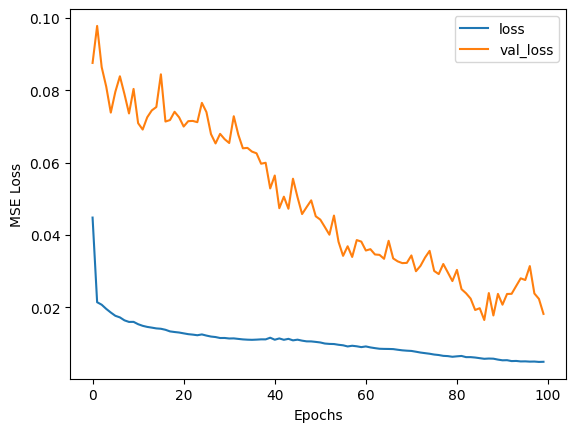

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step - loss: 0.0168
Loss en el conjunto de prueba: 0.018160434439778328
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
Train RMSE: 0.061 RMSE
Test RMSE: 0.135 RMSE


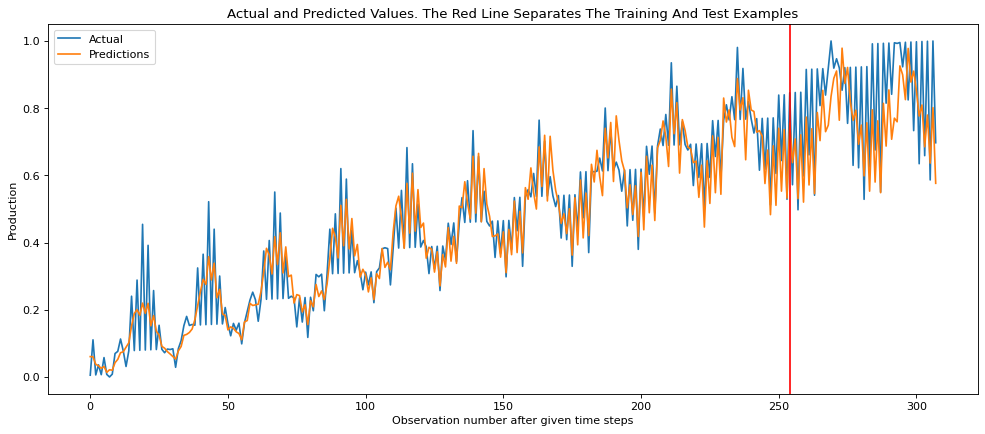

In [10]:
time_steps = 12
forecast_steps = 3
train_data, test_data, data = get_train_test()
trainX, trainY = get_XY(train_data, time_steps, forecast_steps)
testX, testY = get_XY(test_data, time_steps, forecast_steps)

# Create model and train
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(LSTM(200, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history = model.fit(trainX, trainY, epochs=100, batch_size=4, verbose=2, validation_data=(testX, testY))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

# Evaluación del modelo
loss = model.evaluate(testX, testY)
print(f"Loss en el conjunto de prueba: {loss}")

# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# Print error
print_error(trainY, testY, train_predict, test_predict)

#Plot result
plot_result(trainY, testY, train_predict, test_predict)

Se observa una curva loss fluctuante en la validación del modelo de producción de leche, aunque tiene una pendiente negativa, lo cual implica que la pérdida disminuye.

En el caso de las predicciones, el modelo LSTM replica de forma bastante adecuada la serie de tiempo, pero se observa que predice valores inferiores a los reales en los datos iniciales de dicha serie de tiempo.

In [16]:
LSTM_futuro_3 = test_predict[-3:]
LSTM_futuro_3

array([[0.6364605 ],
       [0.80168885],
       [0.57642955]], dtype=float32)

In [17]:
LSTM_futuro = pd.DataFrame({
    'Fecha': ['1976-01', '1976-02', '1976-03'],
    'Producción': LSTM_futuro_3.flatten()
})

In [18]:
LSTM_futuro

,Fecha,Producción
0,1976-01,0.636460
1,1976-02,0.801689
2,1976-03,0.576430


### LSTM en IPSA 1989 a la Fecha


In [ ]:
# Cargar archivo
from google.colab import files
import io
# Cargar archivo desde la máquina local
uploaded2 = files.upload()

# Leer el archivo cargado
file_path = list(uploaded2.keys())[0]
data = pd.read_excel(io.BytesIO(uploaded2[file_path]), sheet_name='Cuadro')

Saving IPSA 1989-2024 Banco Central.xlsx to IPSA 1989-2024 Banco Central.xlsx


#### Carga de datos

In [ ]:
data = pd.read_excel('IPSA 1989-2024 Banco Central.xlsx')

In [ ]:
data_cleaned = data.iloc[2:].reset_index(drop=True)
data_cleaned.columns = ['Periodo', 'IPSA']
data_cleaned = data_cleaned[['Periodo', 'IPSA']]
data_cleaned['Periodo'] = pd.to_datetime(data_cleaned['Periodo'], errors='coerce')
data_cleaned['IPSA'] = pd.to_numeric(data_cleaned['IPSA'], errors='coerce')

#### EDA y análisis de componentes

In [ ]:
data_cleaned.head()

,Periodo,IPSA
0,1989-01-01,54.44
1,1989-02-01,60.57
2,1989-03-01,63.64
3,1989-04-01,68.44
4,1989-05-01,70.72


In [ ]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Periodo  431 non-null    datetime64[ns]
 1   IPSA     431 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.9 KB


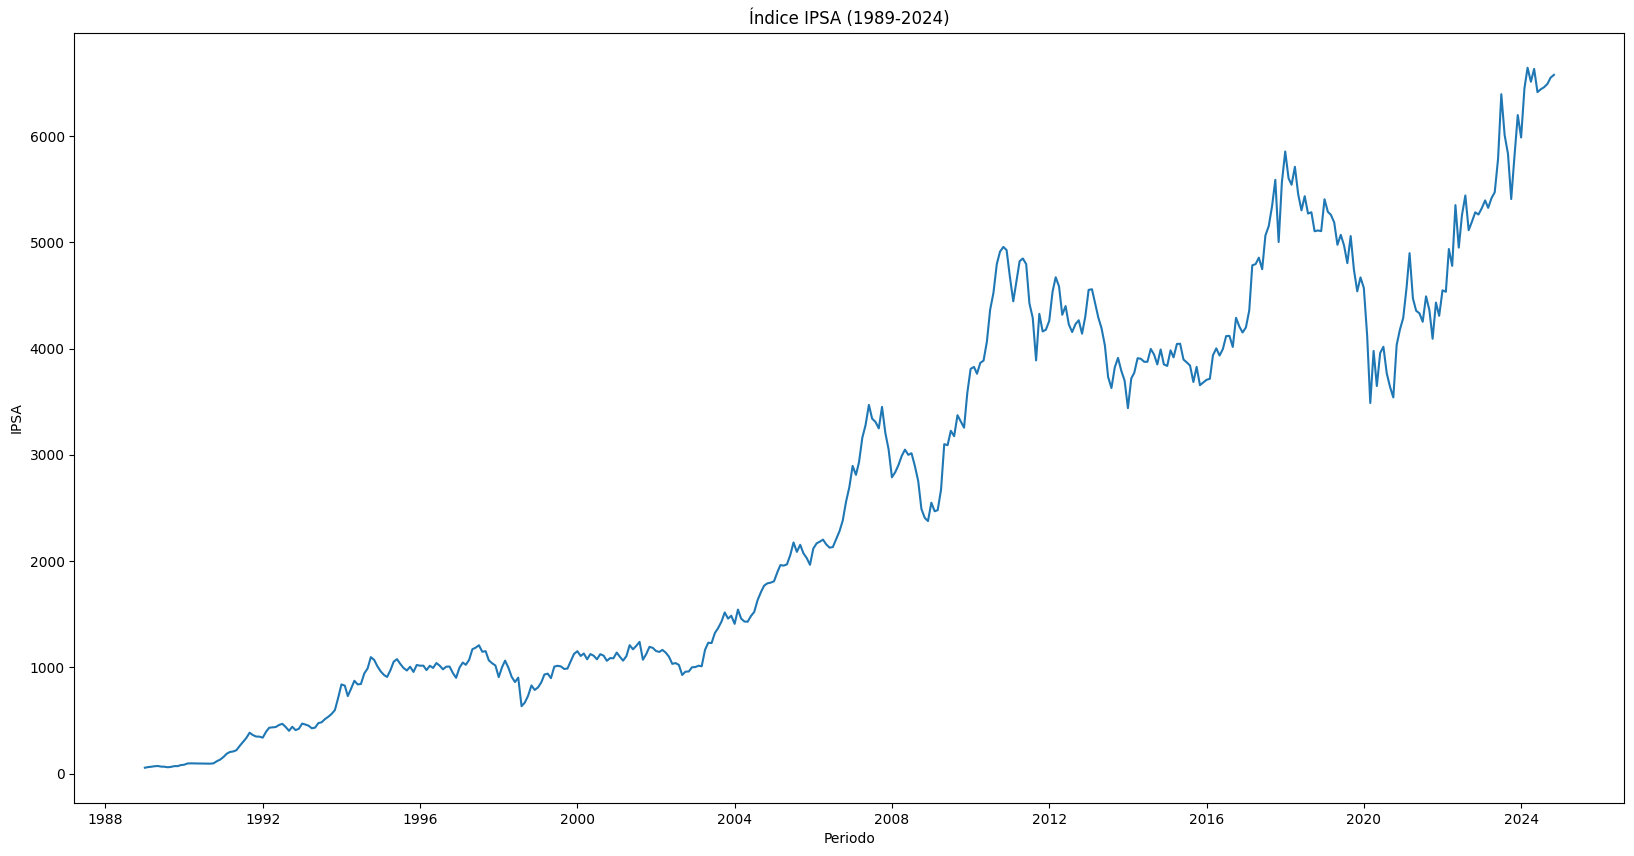

In [ ]:
# Gráfico EDA: Tendencia del IPSA a lo largo del tiempo
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=data_cleaned, x='Periodo', y='IPSA')
plt.title('Índice IPSA (1989-2024)')
plt.show()

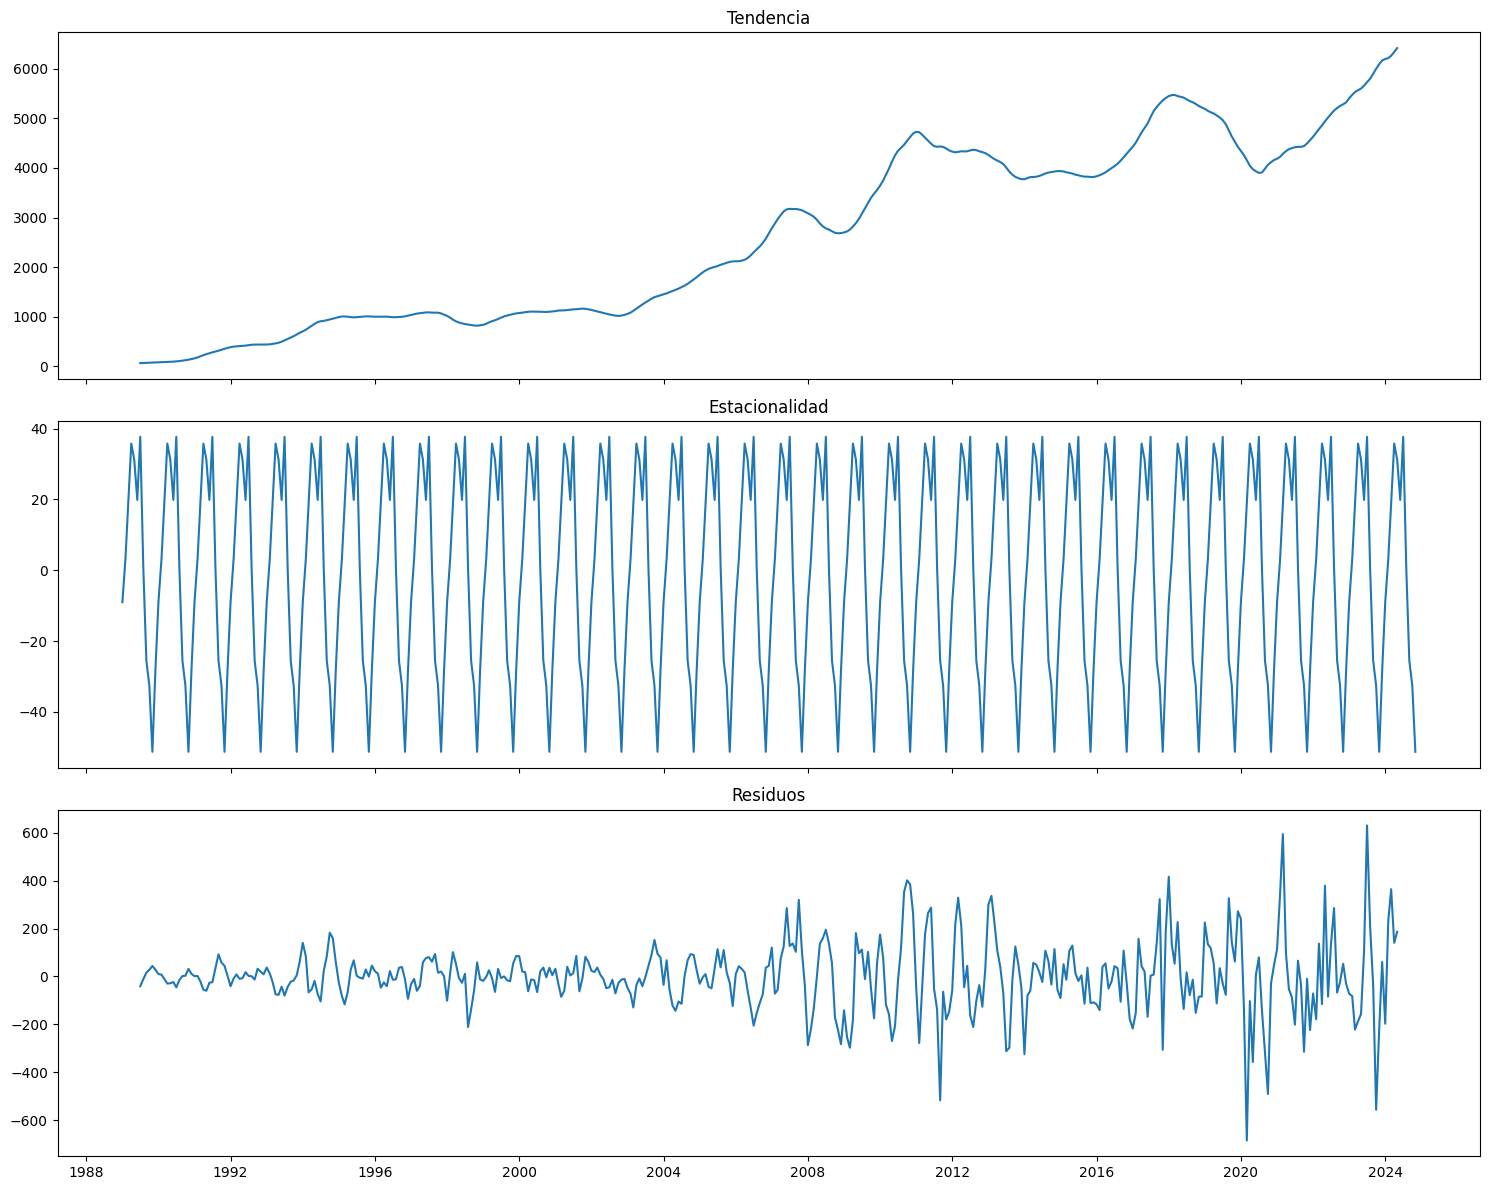

In [ ]:
# Descomposición estacional
decomposition = seasonal_decompose(data_cleaned['IPSA'], model='additive', period=12)
data_cleaned['Trend'] = decomposition.trend
data_cleaned['Seasonal'] = decomposition.seasonal
data_cleaned['Residual'] = decomposition.resid

# Gráfico de descomposición
fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
axs[0].plot(data_cleaned['Periodo'], data_cleaned['Trend'], label='Trend')
axs[0].set_title('Tendencia')
axs[1].plot(data_cleaned['Periodo'], data_cleaned['Seasonal'], label='Seasonality')
axs[1].set_title('Estacionalidad')
axs[2].plot(data_cleaned['Periodo'], data_cleaned['Residual'], label='Residual')
axs[2].set_title('Residuos')
plt.tight_layout()
plt.show()

In [ ]:
data_cleaned['Residual'].mean()

0.2447008928573319

Se observa una tendencia de pendiente positiva en los datos del IPSA, considerando que aunque existen fluctuaciones en las cuales su valor disminuye, su valor tiende a aumentar en el tiempo.

En el caso de la estacionalidad se observa un patrón cíclico con fluctuaciones constantes en el valor del IPSA.

Los residuos tienen un valor promedio igual a 0.245.

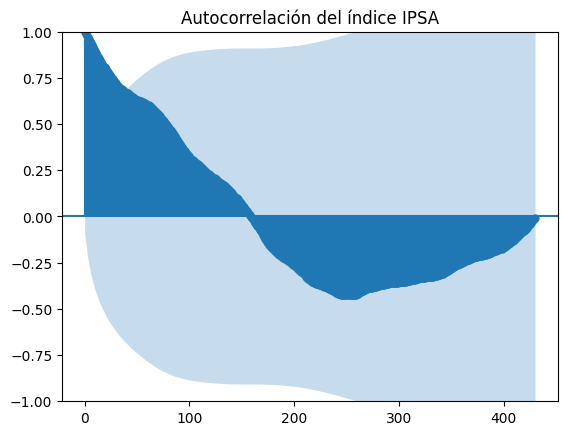

In [ ]:
# Gráfico EDA: Autocorrelación del IPSA
fig = (20, 10)
plot_acf(data_cleaned['IPSA'], lags=430, title='Autocorrelación del índice IPSA', alpha=0.05)
plt.show()

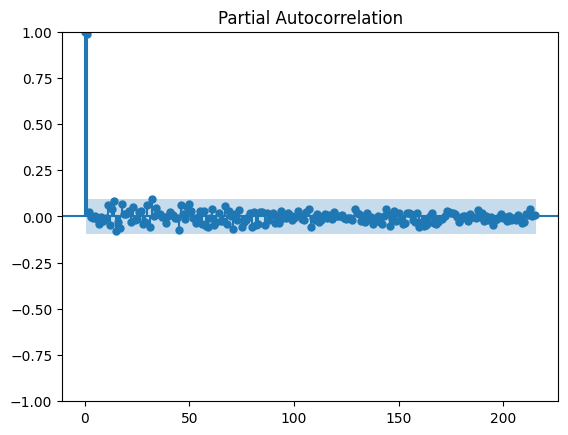

In [ ]:
# Autocorrelación parcial IPSA
plot_pacf(data_cleaned['IPSA'], lags=215)
plt.show()

Luego de observar tanto la evolución de la autocorrelación como de la autocorrelación parcial del valor del IPSA entre los años 1989 y 2024, podemos deducir que se trataría de una serie no estacionaria. A continuación corroboraremos este indicio aplicando la prueba de Dickey-Fuller Aumentada (ADF).

In [ ]:
adf_result = sts.adfuller(data_cleaned['IPSA'])

# Extraer los resultados claves
adf_statistic = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

# Mostrar los resultados de la prueba ADF
adf_statistic, p_value, critical_values

(-0.004413243053797658,
 0.9581655886530982,
 {'1%': -3.445685337552546,
  '5%': -2.868300808913956,
  '10%': -2.570371276889389})

Los resultados de la prueba de **Dickey-Fuller Aumentada (ADF)** para la variable **IPSA** son los siguientes:

- **Estadístico ADF:** resultado -0.0044, cuanto más negativo sea este valor más probable es que la serie sea estacionaria. Si el estadístico ADF es menor (más negativo) que los valores críticos, se puede rechazar la hipótesis nula y concluir que la serie es estacionaria. En este caso, el valor de -0.0044 no es lo suficientemente negativo para superar los valores críticos, lo que sugiere que la serie no es estacionaria.

- **Valor p:** resultado 0.958, esto significa que al ser mayor que el nivel de significancia comúnmente utilizado (0.05, o 5%), no se podría rechazar la hipótesis nula donde se establece que la serie tiene una raíz unitaria. Esto quiere decir, que la prueba sugiere que la serie `no es estacionaria`.

- **Valores críticos:**

    1% -> -3.45 El 1% respresenta un valor crítico muy conservador, lo cual quiere decir que si el estadístico ADF es menor que este valor, hay evidencia muy fuerte que la serie es estacionaria.

    5% -> -2.87 El 5% es un valor conmúnmente utilizado. Si el estadístico ADF es menor que este valor, podemos concluir que la serie es estacionaria.

    10% -> -2.57 El 10% es el valor máximo. En este caso, si el estadístico ADF es menor que este valor, la serie es estacionaria, pero menos convincente.


**En conclusión, gracias a los valores obtenidos mediante la prueba ADF, podemos indicar que la variable IPSA no presenta estacionariedad**

Puntos de quiebre detectados: [60, 190, 250, 400, 431]


<Figure size 1000x600 with 0 Axes>

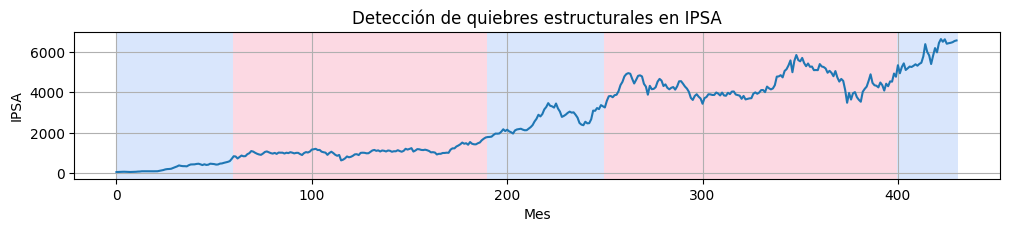

In [ ]:
# Convertir los datos a formato de numpy para aplicar la detección de quiebres
signal = data_cleaned['IPSA'].values

# Crear un modelo para detectar quiebres (usando el método de cambios de media)
algo = rpt.Pelt(model="rbf").fit(signal)

# Definir un valor para penalización (esto determina la sensibilidad para detectar quiebres)
pen = 10

# Identificar quiebres
breakpoints = algo.predict(pen=pen)

# Mostrar los puntos donde se detectaron quiebres
print("Puntos de quiebre detectados:", breakpoints)

# Visualizar los quiebres detectados
plt.figure(figsize=(10, 6))
rpt.display(signal, breakpoints)
plt.title('Detección de quiebres estructurales en IPSA')
plt.xlabel('Mes')
plt.ylabel('IPSA')
plt.grid(True)
plt.show()

Se observan quiebres en la tendencia del valor del IPSA en los meses 60, 190, 250, 400 y 431.

#### Ajuste de modelos

In [ ]:

# Normalización de los valores del IPSA
scaler = MinMaxScaler(feature_range=(0, 1))
data_cleaned['IPSA_normalized'] = scaler.fit_transform(data_cleaned[['IPSA']])

# Crear ventanas de tiempo para LSTM
def create_sequences(data, input_steps, forecast_steps):
    X, Y = [], []
    for i in range(len(data) - input_steps - forecast_steps + 1):
        X.append(data[i:i+input_steps]) # input_steps hacia el pasado
        Y.append(data[i+input_steps+forecast_steps-1])  # Valor 3 meses adelante
    X = np.array(X).reshape(-1, input_steps, 1)
    Y = np.array(Y)
    return X, Y

Se propone un modelo base con 5 pasos autoregresivos y las capas detalladas a continuación.

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0416 - val_loss: 0.0093
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034 - val_loss: 0.0046
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0043 - val_loss: 0.0086
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - val_loss: 0.0211
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029 - val_loss: 0.0140
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031 - val_loss: 0.0174
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031 - val_loss: 0.0126
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0027 - val_loss: 0.0095
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0136
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025 - val_loss: 0.0180
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0028 - val_loss: 0.0141
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0030 - val_loss: 0.0098


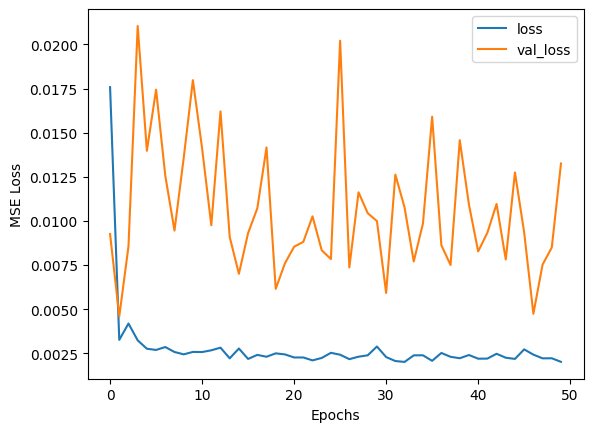

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0107 
Loss en el conjunto de prueba: 0.013256330043077469
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


In [ ]:
input_steps = 5
data_values = data_cleaned['IPSA_normalized'].values
X, y = create_sequences(data_values, input_steps, 3)

# Dividir en conjuntos de entrenamiento y prueba
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Añadir una tercera dimensión a los datos de entrada
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construcción del modelo LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(input_steps, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compilación del modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo
history = model.fit(X_train, y_train, batch_size=4, epochs=50, validation_data=(X_test, y_test))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

# Evaluación del modelo
loss = model.evaluate(X_test, y_test)
print(f"Loss en el conjunto de prueba: {loss}")

# Predicciones
predictions = model.predict(X_test)

Se observa una loss ruidosa en validación, pese a ir en general descendiendo. Se grafican las predicciones:

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


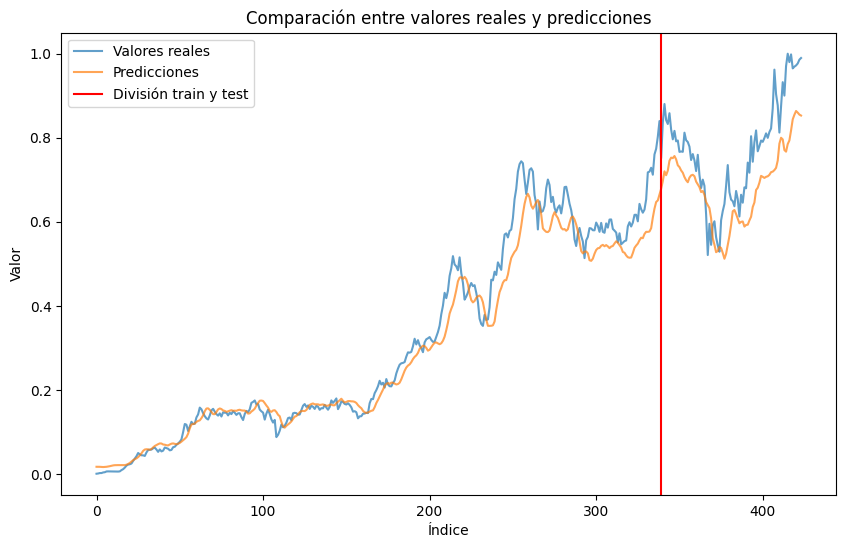

In [ ]:
# Comparación de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.plot(np.concatenate((y_train, y_test)), label='Valores reales', alpha=0.7)
plt.plot(np.concatenate((model.predict(X_train), predictions)), label='Predicciones', alpha=0.7)
plt.title('Comparación entre valores reales y predicciones')
plt.axvline(x=split, label = 'División train y test', c = 'r')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()


Se puede ver que en general se capta la dinámica de la serie temporal, pero en zonas específicas aún es dificultuoso el ajuste (incluso en training). Se incursiona un nuevo modelo con más unidades en cada capa LSTM

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0282 - val_loss: 0.0052
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0038 - val_loss: 0.0108
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0032 - val_loss: 0.0210
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0032 - val_loss: 0.0058
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 0.0067
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0020 - val_loss: 0.0122
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 0.0092
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025 - val_loss: 0.0092
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025 - val_loss: 0.0076
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025 - val_loss: 0.0134
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0030 - val_loss: 0.0137
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0026 - val_loss: 0.00

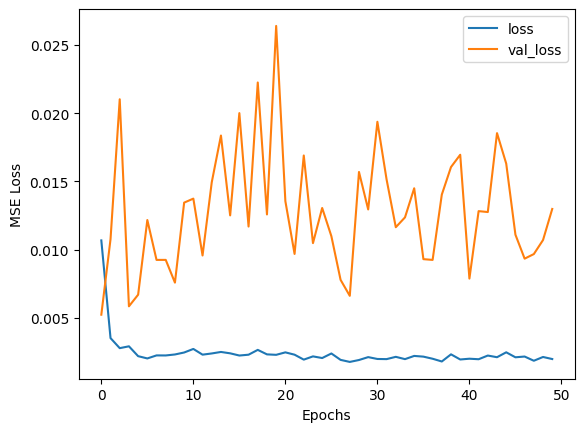

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 
Loss en el conjunto de prueba: 0.012979504652321339
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


In [ ]:
input_steps = 5
data_values = data_cleaned['IPSA_normalized'].values
X, y = create_sequences(data_values, input_steps, 3)

# Dividir en conjuntos de entrenamiento y prueba
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Añadir una tercera dimensión a los datos de entrada
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construcción del modelo LSTM
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(input_steps, 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50),
    Dense(1)
])

# Compilación del modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo
history = model.fit(X_train, y_train, batch_size=4, epochs=50, validation_data=(X_test, y_test))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

# Evaluación del modelo
loss = model.evaluate(X_test, y_test)
print(f"Loss en el conjunto de prueba: {loss}")

# Predicciones
predictions = model.predict(X_test)

Se puede ver que el error cuadrático medio prácticamente no cambió, manteniéndose intacto en 0.01, por lo cual no supone una mejora. Se experimenta ahora aumentando los pasos autoregresivos a 10

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0274 - val_loss: 0.0065
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0043 - val_loss: 0.0092
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0044 - val_loss: 0.0189
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034 - val_loss: 0.0152
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - val_loss: 0.0131
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0042 - val_loss: 0.0134
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0038 - val_loss: 0.0230
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031 - val_loss: 0.0194
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 0.0118
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023 - val_loss: 0.0123
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024 - val_loss: 0.0119
Epoch 12/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_lo

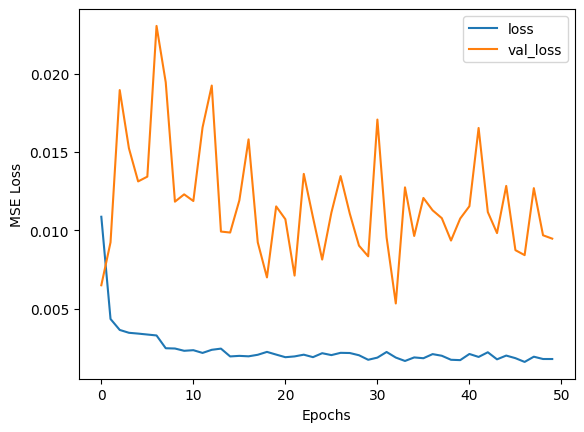

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076  
Loss en el conjunto de prueba: 0.00948087964206934
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


In [ ]:
input_steps = 10
data_values = data_cleaned['IPSA_normalized'].values
X, y = create_sequences(data_values, input_steps, 3)

# Dividir en conjuntos de entrenamiento y prueba
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Añadir una tercera dimensión a los datos de entrada
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construcción del modelo LSTM
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(input_steps, 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50),
    Dense(1)
])

# Compilación del modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo
history = model.fit(X_train, y_train, batch_size=4, epochs=50, validation_data=(X_test, y_test))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

# Evaluación del modelo
loss = model.evaluate(X_test, y_test)
print(f"Loss en el conjunto de prueba: {loss}")

# Predicciones
predictions = model.predict(X_test)

Como se puede ver el error cuadrático medio disminuyó a 0.009. Sin embargo, el ruido en la loss de validación se mantiene, por lo que se aumenta el batch size a 16 (manteniendo los 10 pasos autoregresivos)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0560 - val_loss: 0.0383
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - val_loss: 0.0095
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - val_loss: 0.0112
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0047 - val_loss: 0.0064
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - val_loss: 0.0101
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - val_loss: 0.0144
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - val_loss: 0.0072
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - val_loss: 0.0082
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - val_loss: 0.0083
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - val_loss: 0.0068
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - val_loss: 0.0080
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - val_loss: 0.0072

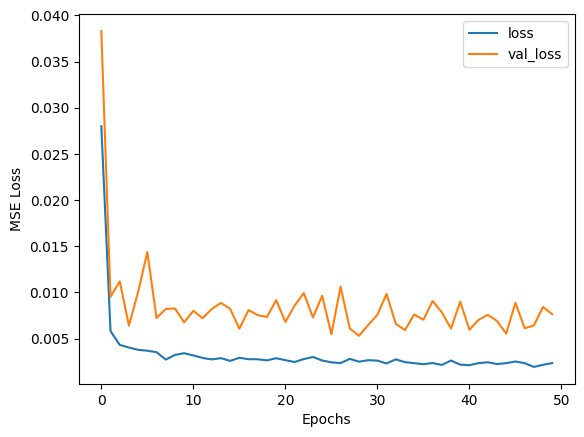

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 
Loss en el conjunto de prueba: 0.007642725948244333
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


In [ ]:
input_steps = 10
data_values = data_cleaned['IPSA_normalized'].values
X, y = create_sequences(data_values, input_steps, 3)

# Dividir en conjuntos de entrenamiento y prueba
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Añadir una tercera dimensión a los datos de entrada
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Construcción del modelo LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(input_steps, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compilación del modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo
history = model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

# Evaluación del modelo
loss = model.evaluate(X_test, y_test)
print(f"Loss en el conjunto de prueba: {loss}")

# Predicciones
predictions = model.predict(X_test)

Se puede ver que el error cuadrático medio disminuyó a aprox 0.007 y además la loss en validación dejó de exhibir un comportamiento excesivamente ruidoso. Se desprende como el mejor modelo

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


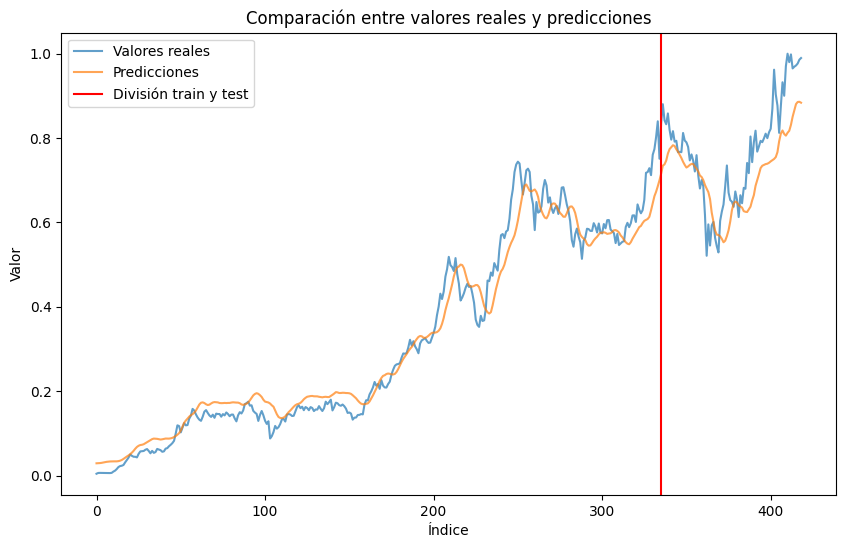

In [ ]:
# Comparación de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.plot(np.concatenate((y_train, y_test)), label='Valores reales', alpha=0.7)
plt.plot(np.concatenate((model.predict(X_train), predictions)), label='Predicciones', alpha=0.7)
plt.title('Comparación entre valores reales y predicciones')
plt.axvline(x=split, label = 'División train y test', c = 'r')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend()
plt.show()

  Se puede ver que en general se captura la tendencia temporal de la serie en el conjunto de test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Resultados Futuros:


<ipython-input-69-fe45d69fb3eb>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=data_cleaned['Periodo'].iloc[-1], periods=4, freq='M')[1:]


,Periodo,1.IPSA (índice enero 2003=1000)
0,2024-12-31,5878.420410
1,2025-01-31,5777.463867
2,2025-02-28,5648.056152


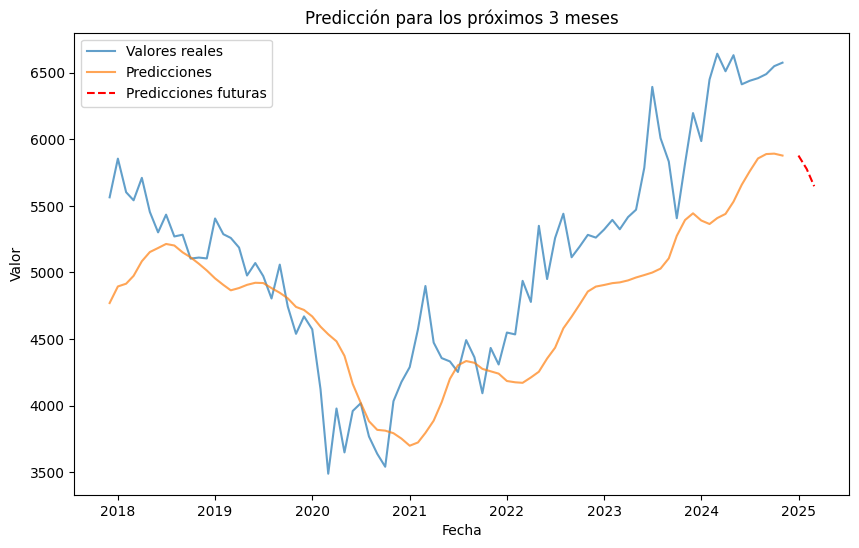

In [ ]:
input_steps = 10
# Predicción de los próximos 3 meses
last_sequence = X_test[-1].reshape(1, 10, 1)
future_predictions = []
for _ in range(3):
    next_prediction = model.predict(last_sequence)[0, 0]
    future_predictions.append(next_prediction)
    next_input = np.append(last_sequence[:, 1:, :], np.expand_dims([[next_prediction]], axis=2), axis=1)
    last_sequence = next_input

# Inversa de la normalización para los valores futuros
future_predictions_real = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Crear un DataFrame para los resultados futuros
future_dates = pd.date_range(start=data_cleaned['Periodo'].iloc[-1], periods=4, freq='M')[1:]
future_results = pd.DataFrame({
    'Periodo': future_dates,
    '1.IPSA (índice enero 2003=1000)': future_predictions_real
})

# Mostrar valores futuros
from IPython.display import display
print("Resultados Futuros:")
display(future_results)

# Crear un gráfico para visualizar las predicciones futuras
plt.figure(figsize=(10, 6))
plt.plot(data_cleaned['Periodo'].iloc[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Valores reales', alpha=0.7)
plt.plot(data_cleaned['Periodo'].iloc[-len(y_test):], scaler.inverse_transform(predictions.reshape(-1, 1)), label='Predicciones', alpha=0.7)
plt.plot(future_dates, future_predictions_real, label='Predicciones futuras', linestyle='--', color='red')
plt.title('Predicción para los próximos 3 meses')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

# Guardar resultados
results = pd.DataFrame({
    'Fecha': data_cleaned['Periodo'].iloc[input_steps + split:input_steps + split + len(y_test)].values,
    'Real': scaler.inverse_transform(y_test.reshape(-1, 1)).flatten(),
    'Predicción': scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
})

## Análisis de resultados

## Conclusiones